In [1]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL, PNDMScheduler
from transformers import T5EncoderModel, T5TokenizerFast
import torch
import os
import numpy as np
import librosa
from tqdm import tqdm
import soundfile as sf
import torchaudio
from IPython.display import Audio
import matplotlib.pyplot as plt

In [2]:
model_path = "/blob/v-yuancwang/AudioEditingModel/Diffusion_SG/checkpoint-350000"
vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained("/blob/v-yuancwang/AUDITPLUS/AUDIT_E/checkpoint-290000")
tokenizer = T5TokenizerFast.from_pretrained(model_path, subfolder="tokenizer")
text_encoder = T5EncoderModel.from_pretrained(model_path, subfolder="text_encoder")

In [ ]:
torch_device = "cuda:2"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)
vae.requires_grad_(False)
unet.requires_grad_(False)
text_encoder.requires_grad_(False)

In [4]:
text = "Repair the audio and increase resolution"

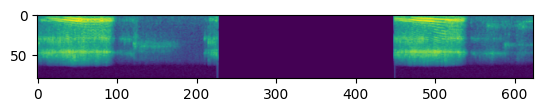

In [5]:
src = np.load("/blob/v-yuancwang/DiffAudioImg/VGGSound/data/ac_train/inpaint/mel/-ejXrr7JYtM_30000_40000.npy")[:,:624]
plt.imshow(src)

In [6]:
prompt = [text]
text_input = tokenizer(prompt, max_length=tokenizer.model_max_length, truncation=True, padding="do_not_pad", return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * 1, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
print(text_embeddings.shape)
print(uncond_embeddings.shape)
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

torch.Size([1, 7, 768])
torch.Size([1, 7, 768])


In [7]:
num_inference_steps = 100
scheduler = PNDMScheduler.from_pretrained(model_path, subfolder="scheduler")
scheduler.set_timesteps(num_inference_steps)

In [ ]:
guidance_scale = 7.5
scheduler.set_timesteps(num_inference_steps)

latents = torch.randn((1, 4, 10, 78)).to(torch_device)
latents_src_input = vae.encode(torch.tensor(src).reshape(1, 1, 80, 624).to(torch_device)).latent_dist.sample()
latents_src_input = torch.cat([latents_src_input] * 2)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(torch.cat((latent_model_input, latents_src_input), dim=1), t, encoder_hidden_states=text_embeddings).sample
    
    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

In [114]:
latents_out = latents

In [115]:
with torch.no_grad():
    res = vae.decode(latents_out).sample
res = res.cpu().numpy()[0,0,:,:]

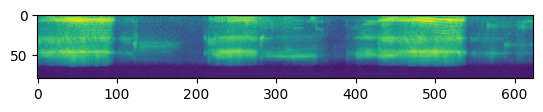

In [116]:
plt.imshow(res)